<a href="https://colab.research.google.com/github/Princess-Mcdonald/Ai-school-princess/blob/main/06_Bayes_Classifier_Princess_Ai__School_Pre_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Imports

In [8]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np


from sklearn.model_selection import train_test_split


%matplotlib inline

# Constants

In [9]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'


# Reading Files

In [10]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [11]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [12]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [13]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [14]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [15]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [16]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [17]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00467.5b733c506b7165424a0d4a298e67970f,This is a multipart MIME message.\n\n\n\n--= M...,1
00063.2334fb4e465fc61e8406c75918ff72ed,IS YOUR BUSINESS MAKING MONEY!\n\nSet Up To Ac...,1
00218.917ed95f5c90c1d9d15d2528b0bd1e79,"Dear Partner to be,\n\n\n\nFirst, I must apolo...",1
00196.dd21040c7757d477c967ae71b537810e,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1
00227.1171cc6d8c586141b4110a2abdccba00,"Dear friend,\n\n\n\nI am Mrs. Sese-seko widow ...",1


In [18]:
spam_emails.shape

(1898, 2)

In [19]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [20]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00467.5b733c506b7165424a0d4a298e67970f,This is a multipart MIME message.\n\n\n\n--= M...,1
00063.2334fb4e465fc61e8406c75918ff72ed,IS YOUR BUSINESS MAKING MONEY!\n\nSet Up To Ac...,1
00218.917ed95f5c90c1d9d15d2528b0bd1e79,"Dear Partner to be,\n\n\n\nFirst, I must apolo...",1
00196.dd21040c7757d477c967ae71b537810e,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1
00227.1171cc6d8c586141b4110a2abdccba00,"Dear friend,\n\n\n\nI am Mrs. Sese-seko widow ...",1


In [21]:
data.tail()

,MESSAGE,CATEGORY
00223.7eb46d1a710b80df0d9700fe631ad9bb,> bad thing. Just a bad thing for those that h...,0
00507.33eb248faaa35e9d98296e66f5af8eb9,"Yes, I know, dreadful subject. However, becaus...",0
00650.72e893edc133cd4fc90b9de30119210d,"Hmm, tricky because we've got Razor1 and Razor...",0
00432.6a1c32a56b122370713c8146238f75dd,Thanks for the tips. The closest I've gotten t...,0
00214.4a5f7fc36eda589a5716dd090c67e90a,\n\n<rant>\n\nI swear to god you have to be so...,0


# Data Cleaning: Checking for Missing Values

In [22]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [23]:
type("")

str

In [24]:
len("")

0

In [25]:
my_var = None

In [26]:
type(my_var)

NoneType

In [27]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [28]:
(data.MESSAGE.str.len() == 0).sum()

3

In [29]:
# Challenge: how would you check the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

### Locate empty emails(data cleaning)

In [30]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [31]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [32]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# Remove System File Entries from Dataframe(Removing empty emails to data)

In [33]:
data.drop(['cmds'], inplace=True)

data[4608:4611]

,MESSAGE,CATEGORY
00425.1af406dc2ac12d1d5140a6ee5fb75231,> Anyone know where in Ireland I can get a rep...,0
00294.0a51c5ddbf67c2e2ac03b2fdc0858acd,"On Fri, 9 Aug 2002, Ryan, Shane wrote:\n\n\n\n...",0
01126.d32e9821c5b4a8c537f1a4614a293a52,"On Fri, 2002-07-19 at 09:09, Jesse Keating wro...",0


In [34]:
data.shape

(5796, 2)

# Adding Document IDs to Track Emails in Dataset

In [35]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [36]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,This is a multipart MIME message.\n\n\n\n--= M...,1,00467.5b733c506b7165424a0d4a298e67970f
1,IS YOUR BUSINESS MAKING MONEY!\n\nSet Up To Ac...,1,00063.2334fb4e465fc61e8406c75918ff72ed
2,"Dear Partner to be,\n\n\n\nFirst, I must apolo...",1,00218.917ed95f5c90c1d9d15d2528b0bd1e79
3,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1,00196.dd21040c7757d477c967ae71b537810e
4,"Dear friend,\n\n\n\nI am Mrs. Sese-seko widow ...",1,00227.1171cc6d8c586141b4110a2abdccba00


In [37]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,> bad thing. Just a bad thing for those that h...,0,00223.7eb46d1a710b80df0d9700fe631ad9bb
5792,"Yes, I know, dreadful subject. However, becaus...",0,00507.33eb248faaa35e9d98296e66f5af8eb9
5793,"Hmm, tricky because we've got Razor1 and Razor...",0,00650.72e893edc133cd4fc90b9de30119210d
5794,Thanks for the tips. The closest I've gotten t...,0,00432.6a1c32a56b122370713c8146238f75dd
5795,\n\n<rant>\n\nI swear to god you have to be so...,0,00214.4a5f7fc36eda589a5716dd090c67e90a


# Save to File using Pandas(Using- to JSON method)

In [38]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [39]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [40]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

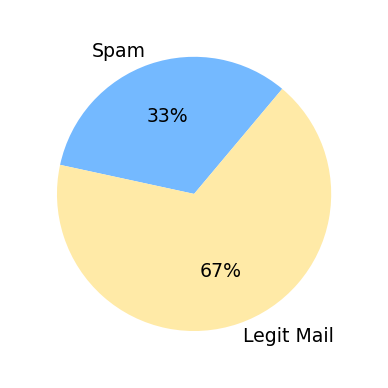

In [41]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#74b9ff', '#ffeaa7']

plt.figure(figsize=(3, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=50, 
       autopct='%1.0f%%', colors=custom_colors)
plt.show()

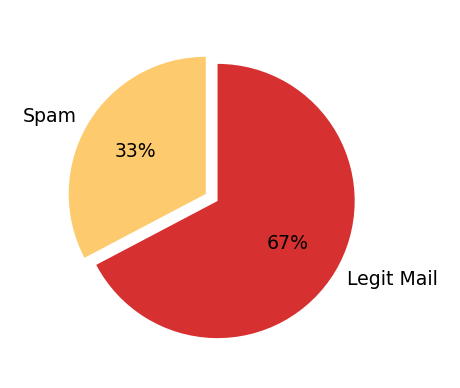

In [42]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#fdcb6e', '#d63031']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

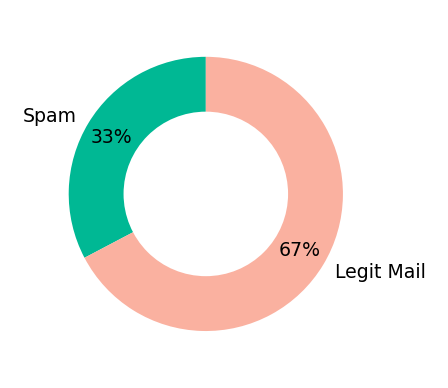

In [43]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#00b894', '#fab1a0']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

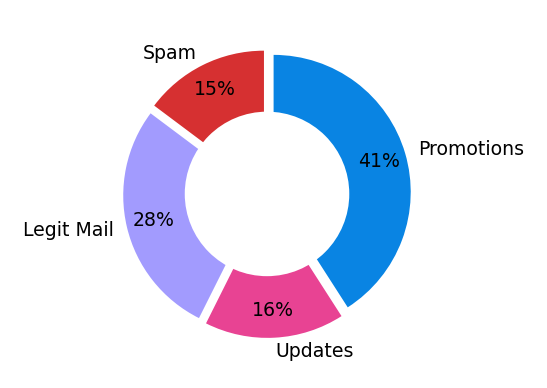

In [44]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [26, 49, 29, 72]
custom_colours = ['#d63031', '#a29bfe', '#e84393', '#0984e3']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing

In [45]:
# convert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [46]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [47]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [48]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package shakespeare to /root/nltk_data...
[nltk_data]   Unzipping corpora/shakespeare.zip.


True

## Tokenising

In [49]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words 

In [50]:
stop_words = set(stopwords.words('english'))

In [51]:
type(stop_words)

set

In [52]:
if 'this' in stop_words: print('Found it!')

Found it!


In [53]:
# Challenge: print out 'Nope. Not in here' if the word "hello" is not contained in stop_words

In [54]:
if 'hello' not in stop_words: print('Nope. Not in here')

Nope. Not in here


In [55]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Stemming

In [56]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [57]:
'p'.isalpha()

True

In [58]:
'?'.isalpha()

False

In [59]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \
      Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails - *Using the model Beautiful soup*

---



In [60]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify()) # Helps to prettify the email

Dear Partner to be,



First, I must apologise to you for using this medium to communicate to you

about this project.



I am a highly placed official of  Government of Nigeria and also a

founding member of the ruling party in Power now,the Peoples Democratic

Party(PDP).



My committee - The Niger Delta Development Corporation(NDDC)-which is in

charge of managing and supervising  the disbursement of oil sales revenues

for the Nigerian government.The revenues  under our control runs into

several hundred of millions of dollars monthly.My self and   

other colleagues in the NDDC are currently in need of a foreign partner

with whose bank account we shall transfer the sum of Forty Nine Million

Five Hundred Thosand United States Dollars($49.5m).This fund accrued to us

as commission for oil sales contracts handled under our supervision.



The fund is presently waiting in the Government Account named CBN/FGN

INDEPENDENT REVENUE account number 400-939134 with J.P.MORGAN CHASE

BANK

In [61]:
# Removing the HTML tag.
soup.get_text()

'Dear Partner to be,\n\n\n\nFirst, I must apologise to you for using this medium to communicate to you\n\nabout this project.\n\n\n\nI am a highly placed official of  Government of Nigeria and also a\n\nfounding member of the ruling party in Power now,the Peoples Democratic\n\nParty(PDP).\n\n\n\nMy committee - The Niger Delta Development Corporation(NDDC)-which is in\n\ncharge of managing and supervising  the disbursement of oil sales revenues\n\nfor the Nigerian government.The revenues  under our control runs into\n\nseveral hundred of millions of dollars monthly.My self and   \n\nother colleagues in the NDDC are currently in need of a foreign partner\n\nwith whose bank account we shall transfer the sum of Forty Nine Million\n\nFive Hundred Thosand United States Dollars($49.5m).This fund accrued to us\n\nas commission for oil sales contracts handled under our supervision.\n\n\n\nThe fund is presently waiting in the Government Account named CBN/FGN\n\nINDEPENDENT REVENUE account number

## Functions for Email Processing

In [62]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [63]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [64]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [65]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['dear',
 'partner',
 'first',
 'must',
 'apologis',
 'use',
 'medium',
 'commun',
 'project',
 'highli',
 'place',
 'offici',
 'govern',
 'nigeria',
 'also',
 'found',
 'member',
 'rule',
 'parti',
 'power',
 'peopl',
 'democrat',
 'parti',
 'pdp',
 'committe',
 'niger',
 'delta',
 'develop',
 'corpor',
 'nddc',
 'charg',
 'manag',
 'supervis',
 'disburs',
 'oil',
 'sale',
 'revenu',
 'nigerian',
 'revenu',
 'control',
 'run',
 'sever',
 'hundr',
 'million',
 'dollar',
 'self',
 'colleagu',
 'nddc',
 'current',
 'need',
 'foreign',
 'partner',
 'whose',
 'bank',
 'account',
 'shall',
 'transfer',
 'sum',
 'forti',
 'nine',
 'million',
 'five',
 'hundr',
 'thosand',
 'unit',
 'state',
 'dollar',
 'fund',
 'accru',
 'us',
 'commiss',
 'oil',
 'sale',
 'contract',
 'handl',
 'supervis',
 'fund',
 'present',
 'wait',
 'govern',
 'account',
 'name',
 'independ',
 'revenu',
 'account',
 'number',
 'chase',
 'bank',
 'new',
 'independ',
 'verifictaion',
 'howev',
 'virtu',
 'posit',
 'civil'

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [66]:
data.iat[2, 2]

'00218.917ed95f5c90c1d9d15d2528b0bd1e79'

In [67]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,++++++++++++++++++++++++++++++++++++++++++++++...,1,00382.98464d934c8402ef42e6dbdb07b18a65
6,Wind up your mates today! Please visit http://...,1,00158.9c8bf53ed738031b4bfab819c4b3ef13
7,\n\n<html><body><pre>\n\n\n\n_________________...,1,00119.7bd666ac52f079fb3b5ff0be83b55286
8,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1,00455.c48d026b0aae9a1a14e9ab1193a2a5f3
9,=============================================\...,1,00444.33afc8c1f9cea3100ca8502e8a785259
10,"REGISTER .COM, .BIZ, AND .INFO DOMAINS FOR ONL...",1,00292.dbf78a2aaa230d288eb80ab843804252


In [68]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message) #Using Pandas (.apply) function to add the fuction(clean_message) to the selected emails

In [69]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist] # Using list comprehension 
        
len(flat_list)

635

In [70]:
flat_list

['multipart',
 'mime',
 'messag',
 'multipart',
 'boundari',
 'html',
 'head',
 'bodi',
 'p',
 'center',
 'span',
 'arial',
 'color',
 'black',
 'receiv',
 'email',
 'receiv',
 'special',
 'offer',
 'optind',
 'one',
 'market',
 'partner',
 'feel',
 'receiv',
 'email',
 'error',
 'wish',
 'receiv',
 'addit',
 'special',
 'offer',
 'pleas',
 'repli',
 'email',
 'word',
 'quot',
 'remov',
 'quot',
 'subject',
 'line',
 'follow',
 'unsubscrib',
 'instruct',
 'p',
 'p',
 'p',
 'http',
 'img',
 'http',
 'div',
 'center',
 'strong',
 'font',
 'arial',
 'incred',
 'deal',
 'inkjet',
 'cartridg',
 'div',
 'center',
 'strong',
 'font',
 'arial',
 'price',
 'start',
 'low',
 'div',
 'center',
 'strong',
 'font',
 'arial',
 'check',
 'deal',
 'div',
 'center',
 'nbsp',
 'div',
 'center',
 'http',
 'img',
 'http',
 'div',
 'center',
 'nbsp',
 'div',
 'center',
 'font',
 'arial',
 'strong',
 'check',
 'web',
 'site',
 'incred',
 'deal',
 'div',
 'center',
 'nbsp',
 'div',
 'center',
 'http',
 'img'

In [71]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 38.8 s, sys: 171 ms, total: 38.9 s
Wall time: 39.1 s


In [72]:
nested_list.tail()

DOC_ID
5791    [bad, thing, bad, thing, hope, distro, work, b...
5792    [ye, know, dread, subject, howev, custom, inis...
5793    [hmm, tricki, got, roll, one, rule, probabl, b...
5794    [thank, tip, closest, gotten, get, work, justi...
5795    [swear, god, careful, dell, machin, linux, lap...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [73]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [74]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,Dear fma =2C\n\n\n\n=3CBODY bgColor=3D#ffccff=...,1,01290.cc97aad0960efa7c8b76464b39d54bc9
1892,------=_NextPart_000_00D1_50E24C7B.C3584B84\n\...,1,01191.3a3ed1eb843a56504a4b40a25a63f97f
1893,"<html><body>\n\n\n\n<table bgcolor=3D""#FF6666""...",1,01112.ded20e59cd4ac9ad9607ce6cfe268ecc
1894,"Dear hulkjr ,\n\n\n\nWANT THE BEST IN COMPUTER...",1,01183.1686c7ca72908096192dc3ebcde515d9
1895,--------------6778712SOS1\n\nContent-Type: mul...,1,00398.64f68a9650595170b0e10cc493020a0a


In [75]:
# Challenge: create two variables (doc_ids_spam, doc_ids_ham) which 
# hold onto the indices for the spam and the non-spam emails respectively. 

In [76]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [77]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [78]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [79]:
type(nested_list)

pandas.core.series.Series

In [80]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [81]:
nested_list_ham.shape

(3900,)

In [82]:
nested_list_ham.tail()

DOC_ID
5791    [bad, thing, bad, thing, hope, distro, work, b...
5792    [ye, know, dread, subject, howev, custom, inis...
5793    [hmm, tricki, got, roll, one, rule, probabl, b...
5794    [thank, tip, closest, gotten, get, work, justi...
5795    [swear, god, careful, dell, machin, linux, lap...
Name: MESSAGE, dtype: object

In [83]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [84]:
# Challenge: use python list comprehension and then find the total number of 
# words in our cleaned dataset of spam email bodies. Also find the total number of 
# words in normal emails in the dataset. Then find the 10 most common words used in 
# spam. Also, find the 10 most common words used in non-spam messages. 

In [85]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20816

In [86]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [87]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

13354

In [88]:
spammy_words[:10]

http      3111
email     3094
free      2585
click     2061
receiv    1989
list      1974
get       1914
pleas     1857
busi      1792
order     1746
dtype: int64

# Creating a Word Cloud

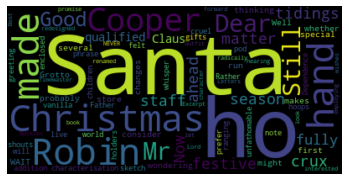

In [89]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [90]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [91]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [92]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [93]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

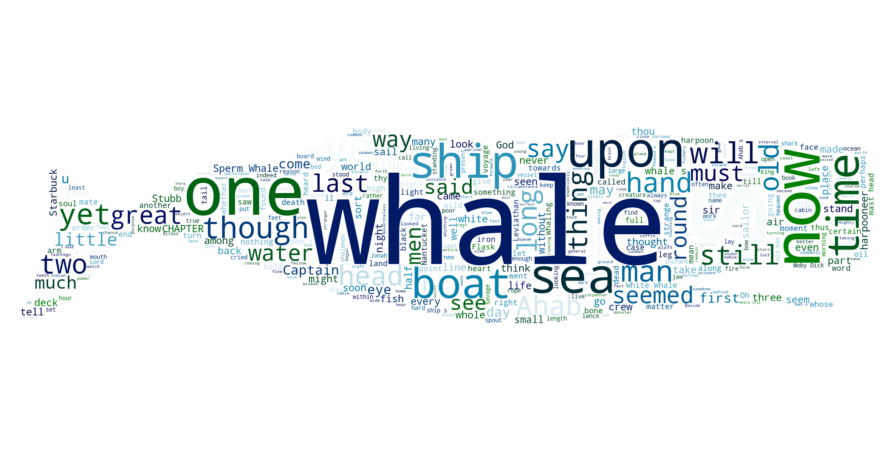

In [94]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=400, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [95]:
rgb_array.shape

(1024, 2048, 3)

In [96]:
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

In [97]:
rgb_array[500, 1000]

array([0, 0, 0], dtype=uint8)

In [98]:
# Challenge: use the skull image in the lesson resources to create a word cloud
# for Shakespeare's play Hamlet

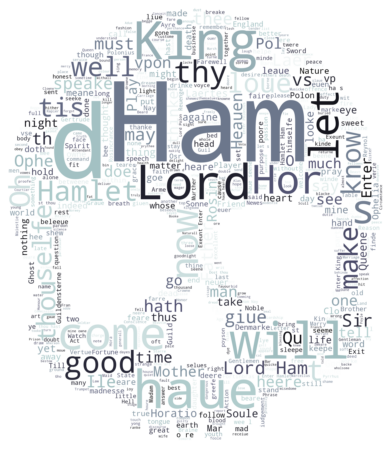

In [99]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      colormap='bone', max_words=600)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

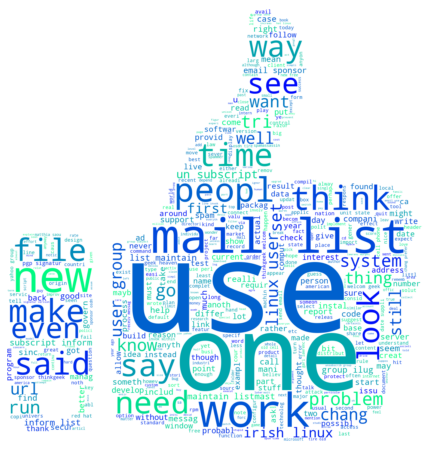

In [100]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [101]:
# Challenge: Look at the word cloud documentation. Use the custom font included in the 
# lesson resources instead of the default font and create a word cloud of the spammy words

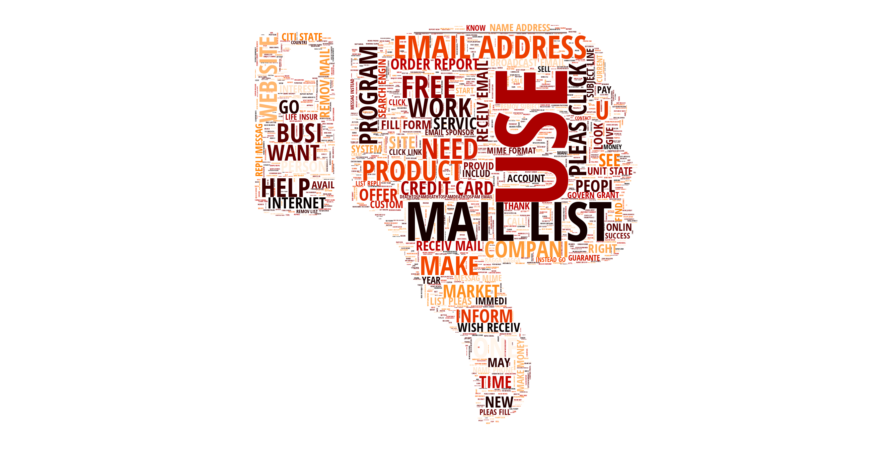

In [102]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [103]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [104]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27420


http     10674
use       5021
list      4854
email     4371
get       4200
dtype: int64

In [105]:
# Challenge: Create subset of the series called 'frequent_words' that only contains
# the most common 2,500 words out of the total. Print out the top 10 words

In [106]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10674
use       5021
list      4854
email     4371
get       4200
mail      3985
one       3907
free      3202
time      3091
work      2883
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [107]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [108]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of the Vocabulary

In [109]:
# Challenge: Write a line of code that checks if a particular word is part 
# of the vocabulary. Your code should return True if the word is among the 
# 2,500 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

In [110]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [111]:
'brew' in set(vocab.VOCAB_WORD) # better way

False

# Exercise: Find the Email with the Most Number of Words

In [112]:
# Challenge: Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data dataframe.

# Hint: use the len() function and practice list comprehension

In [113]:
# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [114]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))


Nr words in the longest email: 7671


In [115]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))


Email position in the list (and the data dataframe) 5386


In [116]:
stemmed_nested_list[np.argmax(clean_email_lengths)]


['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [117]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']


'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [118]:
type(stemmed_nested_list)

pandas.core.series.Series

In [119]:
type(stemmed_nested_list.tolist())

list

In [120]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,multipart,mime,messag,multipart,boundari,receiv,email,receiv,special,offer,...,None,None,None,None,None,None,None,None,None,None
1,busi,make,money,set,accept,credit,card,today,oblig,consult,...,None,None,None,None,None,None,None,None,None,None
2,dear,partner,first,must,apologis,use,medium,commun,project,highli,...,None,None,None,None,None,None,None,None,None,None
3,norton,ad,take,control,comput,softwar,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
4,dear,friend,widow,late,presid,mobutu,zair,known,democrat,republ,...,None,None,None,None,None,None,None,None,None,None


In [121]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [122]:
# Challenge: Can you split the data into a training and testing set? Set the test size at 30%. 
# The training data should include 4057 emails. Use a seed value of 42 to shuffle the data. 
# What should the target values be? 

In [123]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [124]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [125]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,hmmm,rumsfeld,cheney,white,hous,presid,say,crook,tape,market,...,None,None,None,None,None,None,None,None,None,None
4727,common,problem,build,file,think,cross,compil,realli,fact,featur,...,None,None,None,None,None,None,None,None,None,None
5022,mon,jul,paul,kelli,claim,think,matthew,french,wrote,happi,...,None,None,None,None,None,None,None,None,None,None
3504,url,http,date,suppli,research,say,made,least,atom,cold,...,None,None,None,None,None,None,None,None,None,None
3921,mon,aug,ander,eriksson,said,check,number,small,messag,big,...,None,None,None,None,None,None,None,None,None,None


In [126]:
y_train.head()


DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [127]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [128]:
word_index.get_loc('thu')

392

In [129]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [ ]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [ ]:
sparse_train_df[:5]

In [ ]:
sparse_train_df.shape

In [ ]:
sparse_train_df[-5:]

### Combine Occurrences with the Pandas groupby() Method

In [ ]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

In [ ]:
vocab.at[0, 'VOCAB_WORD']

In [ ]:
data.MESSAGE[0]

In [ ]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

In [ ]:
train_grouped.tail()

In [ ]:
vocab.at[1923, 'VOCAB_WORD']

In [ ]:
data.MESSAGE[5795]

In [ ]:
train_grouped.shape

### Save Training Data as .txt File

In [ ]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [ ]:
train_grouped.columns

# Challenge

Can you create a sparse matrix for the test data. Group the occurrences of the same word in the same email. Then save the data as a .txt file. 

In [ ]:
X_test.head()

In [ ]:
y_test.head()

In [ ]:
X_test.shape

In [ ]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [ ]:
sparse_test_df.shape

In [ ]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

In [ ]:
test_grouped.shape

In [ ]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and Checking your Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing. 

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out.

In [ ]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [ ]:
len(test_doc_ids)

In [ ]:
len(X_test)

In [ ]:
set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing

In [ ]:
data.MESSAGE[14]

In [ ]:
data.loc[14]

In [ ]:
clean_msg_no_html(data.at[14, 'MESSAGE'])

In [ ]:
data.MESSAGE[1096]

In [ ]:
clean_msg_no_html(data.at[1096, 'MESSAGE'])

In [ ]:
clean_message(data.at[1096, 'MESSAGE'])